# ====================================================
## TFM: Aprendizaje No Supervisado para Clustering Musical
## Autor: Javier Cables Chozas
# ====================================================

## Librerías y Configuración Inicial
Se importan todas las librerías necesarias para el sistema de agrupación automática de pistas musicales mediante aprendizaje no supervisado. Se configuran también las herramientas de visualización y se suprimen las advertencias para un output más limpio durante el procesamiento.

In [1]:
import os
import warnings

import pandas as pd
import numpy as np

import librosa

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan

from sklearn.metrics import silhouette_score, adjusted_rand_score 

import itertools

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Exploración y Configuración del Dataset
Se verifica la estructura del dataset GTZAN, se confirma la disponibilidad de los géneros musicales y se realiza un conteo inicial de archivos por categoría. Es fundamental para validar la integridad del dataset antes de proceder con el análisis y procesamiento de audio.

In [2]:
# Definir ruta del dataset
general_path = "Data"
data_path = f"{general_path}/genres_original"

# Listar géneros disponibles
genres = [genre for genre in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, genre))]
print(f"Géneros encontrados: {genres}")
print(f"Total de géneros: {len(genres)}\n")

# Contar archivos por género
genre_counts = {}
total_files = 0

for genre in genres:
    genre_path = os.path.join(data_path, genre)
    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
    genre_counts[genre] = len(files)
    total_files += len(files)
    print(f"{genre}: {len(files)} archivos")

print(f"\nTotal de archivos: {total_files}")

Géneros encontrados: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total de géneros: 10

blues: 100 archivos
classical: 100 archivos
country: 100 archivos
disco: 100 archivos
hiphop: 100 archivos
jazz: 100 archivos
metal: 100 archivos
pop: 100 archivos
reggae: 100 archivos
rock: 100 archivos

Total de archivos: 1000


In [3]:
sample_y, sample_sr = librosa.load(f'{data_path}/hiphop/hiphop.00033.wav')

## Detección de Pistas de Audio por Género
Esta función localiza automáticamente archivos de audio WAV dentro de directorios organizados por género musical. Es una utilidad fundamental para navegación automática del dataset GTZAN, proporcionando una interfaz consistente para acceso a archivos individuales durante el procesamiento.

In [4]:
def track_by_gender(genre_folder):
    """
    Devuelve la ruta de la pista .wav encontrada en la carpeta del género.
    """
    for f in sorted(os.listdir(genre_folder)):
        if f.endswith(".wav"):
            return os.path.join(genre_folder, f)
    raise FileNotFoundError("No se encontró archivo .wav en " + genre_folder)

# Audio Features
## Onda de sonido (Sound Waves)
Las ondas de sonido son oscilaciones mecánicas que se propagan a través de un medio en forma de variaciones de presión. En el procesamiento digital de audio, estas ondas se representan como una señal unidimensional (1D) continua o discretizada que refleja la amplitud del sonido a lo largo del tiempo.

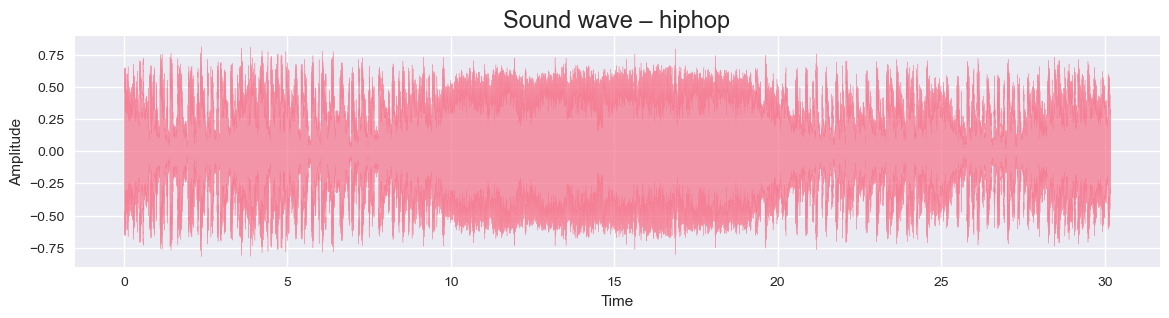

In [5]:
def show_soundwave(y, sr, genre):
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.7)
    plt.title(f"Sound wave – {genre}", fontsize = 17)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

show_soundwave(sample_y, sample_sr, 'hiphop')

## Short-time Fourier transform (STFT)
La STFT descompone una señal de audio en sus componentes de frecuencia locales, aplicando la Transformada de Fourier sobre segmentos cortos y solapados de la señal. Esta técnica permite obtener una representación tiempo-frecuencia, revelando cómo varía el contenido espectral a lo largo del tiempo.

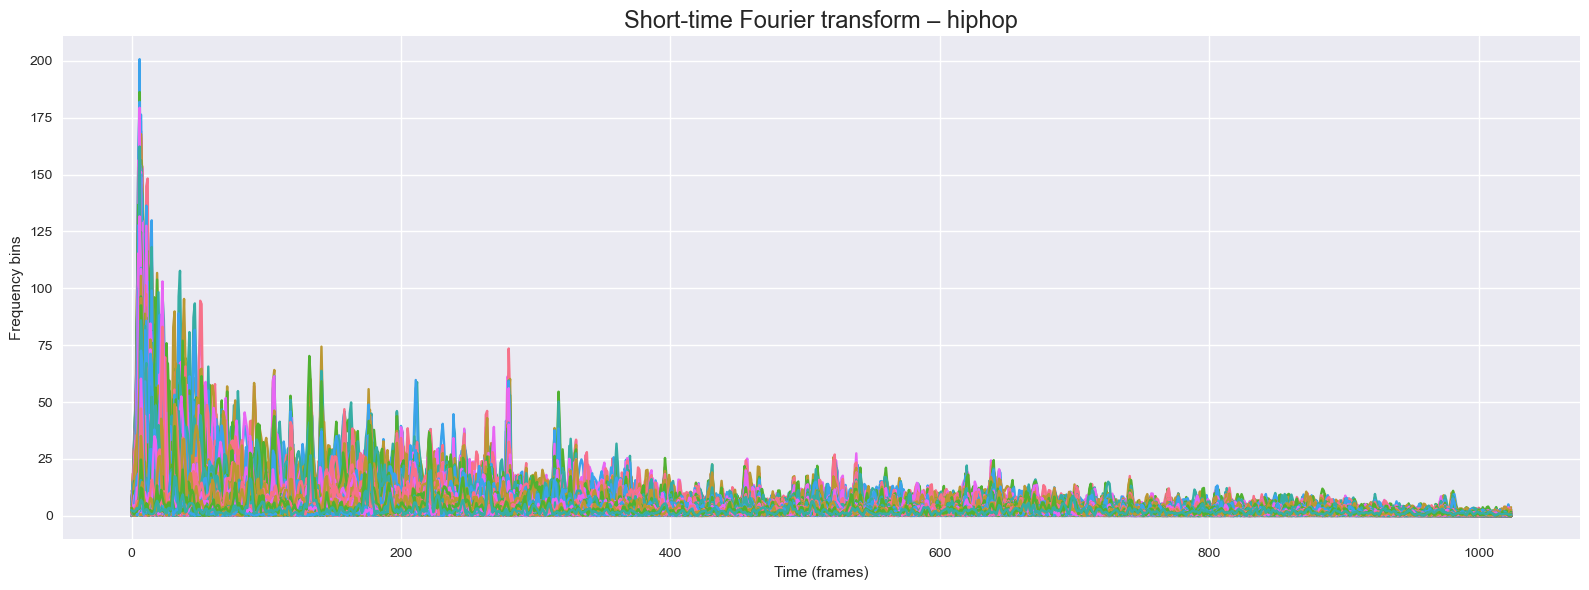

In [6]:
def show_stft(y, genre):
    # FFT simple de toda la señal
    n_fft = 2048 # Tamaño de la ventana FFT
    hop_length = 512 # Número audio de fotogramas entre columnas STFT
    
    audio_file, _ = librosa.effects.trim(y)
    
    D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))
    
    plt.figure(figsize = (16, 6))
    plt.title(f"Short-time Fourier transform – {genre}", fontsize = 17)
    plt.plot(D)
    plt.xlabel("Time (frames)")
    plt.ylabel("Frequency bins")
    plt.tight_layout()

show_stft(sample_y, 'hiphop')

## Mel Spectrogram
El espectrograma de Mel es una representación espectral de la energía de una señal en el dominio tiempo-frecuencia, transformado a la escala Mel, que aproxima la percepción auditiva humana. Se obtiene aplicando un banco de filtros triangular en la escala Mel sobre la magnitud del STFT.

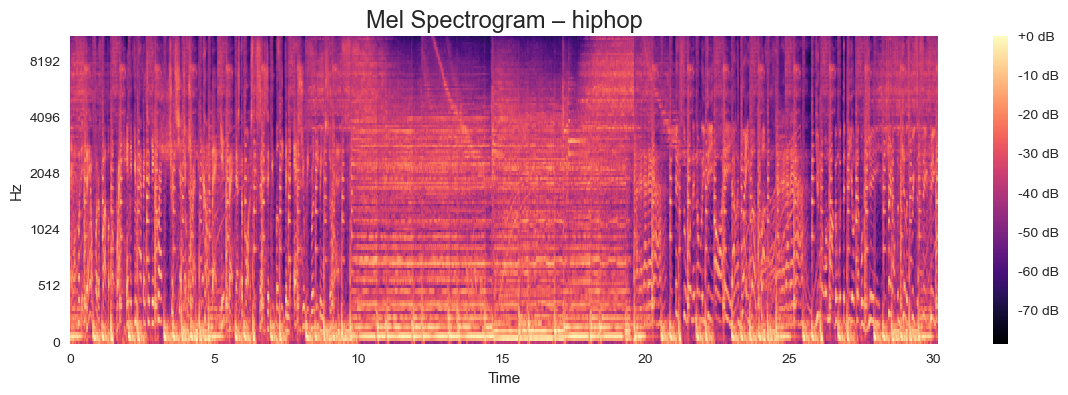

In [7]:
def show_mel_spectogram(y, sr, genre):
    S = librosa.feature.melspectrogram(y = y, sr = sr, n_mels = 128, hop_length = 512)
    S_dB = librosa.power_to_db(S, ref = np.max)
    
    plt.figure(figsize = (14, 4))
    librosa.display.specshow(S_dB, sr = sr, hop_length=512, x_axis = 'time', y_axis = 'mel', cmap = 'magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram – {genre}", fontsize = 17)
    plt.show()

show_mel_spectogram(sample_y, sample_sr, 'hiphop')

## Zero Crossing Rate
El índice de cruces por cero mide la frecuencia con la que una señal de audio cambia de signo (de positivo a negativo o viceversa) por unidad de tiempo. Es una característica útil para distinguir sonidos ruidosos o sin tono definido, como percusiones, de sonidos tonales.

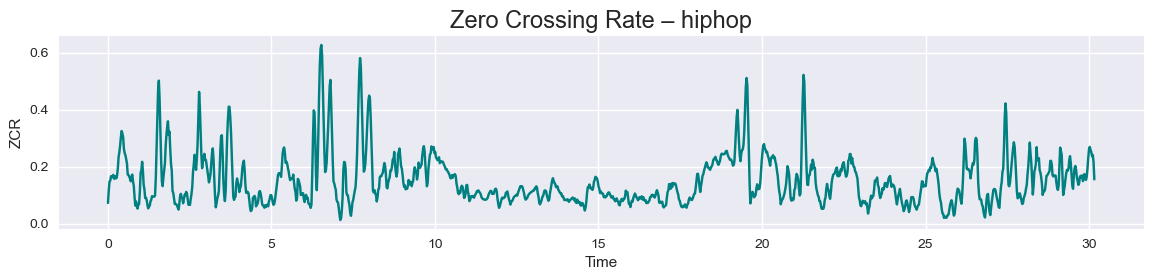

In [8]:
def show_zcr(y, sr, genre):
    zcr = librosa.feature.zero_crossing_rate(y, hop_length = 512)[0]
    times = librosa.times_like(zcr, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 2.5))
    plt.plot(times, zcr, color = 'teal')
    plt.title(f"Zero Crossing Rate – {genre}", fontsize = 17)
    plt.xlabel("Time")
    plt.ylabel("ZCR")
    plt.show()

show_zcr(sample_y, sample_sr, 'hiphop')

## Harmonics and Perceptrual (HPSS)
HPSS es una técnica que separa una señal de audio en dos componentes: armónica (estable en el tiempo, tonal) y percusiva (transitoria, estable en frecuencia). Se basa en la regularidad de los componentes espectrales en el dominio STFT.

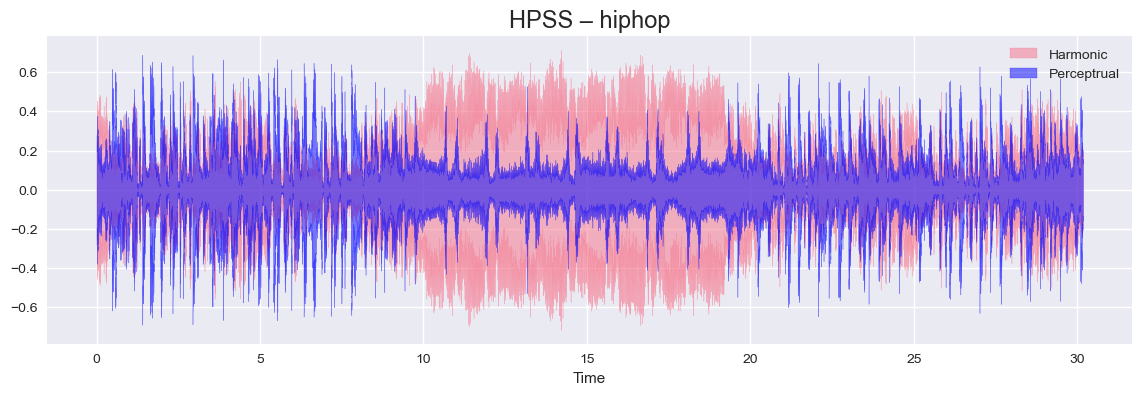

In [9]:
def show_hpss(y, sr, genre):
    harm, perc = librosa.effects.hpss(y)
    
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(harm, sr = sr, alpha=0.5, label = 'Harmonic')
    librosa.display.waveshow(perc, sr = sr, color = 'b', alpha=0.5, label = 'Perceptrual')
    plt.title(f"HPSS – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_hpss(sample_y, sample_sr, 'hiphop')

## Tempo BMP
El tempo representa la velocidad de una pieza musical, medido en golpes por minuto (BPM). Se estima mediante técnicas de detección de eventos rítmicos y autocorrelación sobre la señal de energía.

Tempo estimado: 95.7 BPM


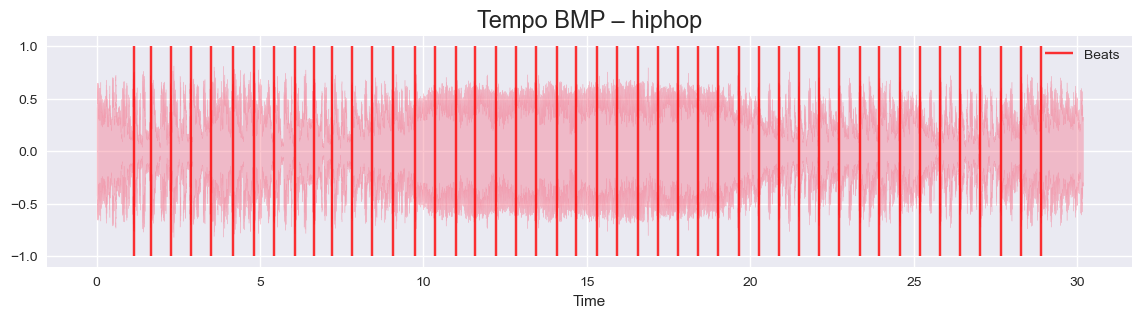

In [10]:
def show_bpm(y, sr, genre):
    # Estimación de tempo (BPM) y beats
    tempo, beats = librosa.beat.beat_track(y = y, sr = sr, units = 'time')
    
    # Si el tempo es un array, lo convertimos a escalar
    if isinstance(tempo, np.ndarray):
        tempo = float(tempo.squeeze())
    
    print(f"Tempo estimado: {tempo:.1f} BPM")
    
    # Visualización del audio y los beats detectados
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.vlines(beats, -1, 1, color = 'red', alpha = 0.8, label = 'Beats')
    plt.title(f"Tempo BMP – {genre}", fontsize = 17)
    plt.xlabel("Time")
    plt.legend()
    plt.show()

show_bpm(sample_y, sample_sr, 'hiphop')

## Spectral Centroid
El centroide espectral representa el promedio ponderado de las frecuencias presentes en una señal, donde el peso es la magnitud espectral. Indica dónde se concentra la energía espectral y se asocia con el brillo perceptual del sonido.

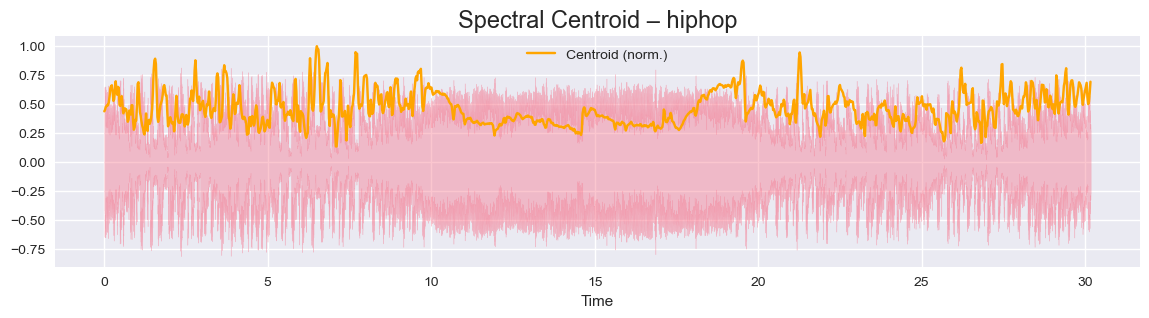

In [11]:
def show_spectral_centroid(y, sr, genre):
    centroid = librosa.feature.spectral_centroid(y = y, sr = sr, hop_length = 512)[0]
    centroid_norm = centroid / centroid.max()            # para escalar en la onda
    times = librosa.times_like(centroid, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.plot(times, centroid_norm, color = 'orange', label = 'Centroid (norm.)')
    plt.title(f"Spectral Centroid – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_spectral_centroid(sample_y, sample_sr, 'hiphop')

## Spectral Rolloff
El rolloff espectral es la frecuencia por debajo de la cual se encuentra un porcentaje acumulado (usualmente 85%) de la energía espectral. Es un descriptor del contenido de alta frecuencia de una señal y se utiliza para caracterizar el timbre.

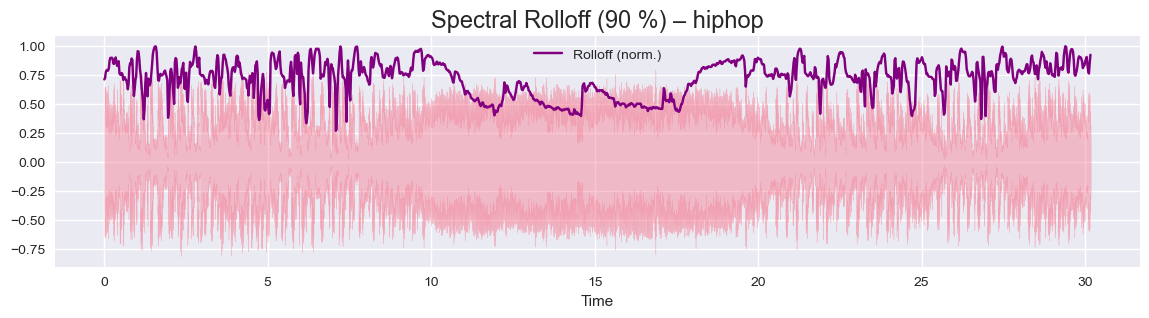

In [12]:
def show_spectral_rolloff(y, sr, genre):
    rolloff = librosa.feature.spectral_rolloff(y = y, sr = sr, hop_length = 512, roll_percent = 0.90)[0]
    rolloff_norm = rolloff / rolloff.max()
    times = librosa.times_like(rolloff, sr = sr, hop_length = 512)
    
    plt.figure(figsize = (14, 3))
    librosa.display.waveshow(y, sr = sr, alpha = 0.4)
    plt.plot(times, rolloff_norm, color = 'purple', label = 'Rolloff (norm.)')
    plt.title(f"Spectral Rolloff (90 %) – {genre}", fontsize = 17)
    plt.legend()
    plt.show()

show_spectral_rolloff(sample_y, sample_sr, 'hiphop')

## MFCC (Mel-Frequency Cepstral Coefficients)
Los coeficientes cepstrales en la escala Mel son una representación compacta de la envolvente espectral de una señal, obtenida mediante una transformada discreta del coseno (DCT) aplicada al logaritmo del espectrograma de Mel. Capturan características timbrales del sonido y son ampliamente usados en reconocimiento de voz y música.

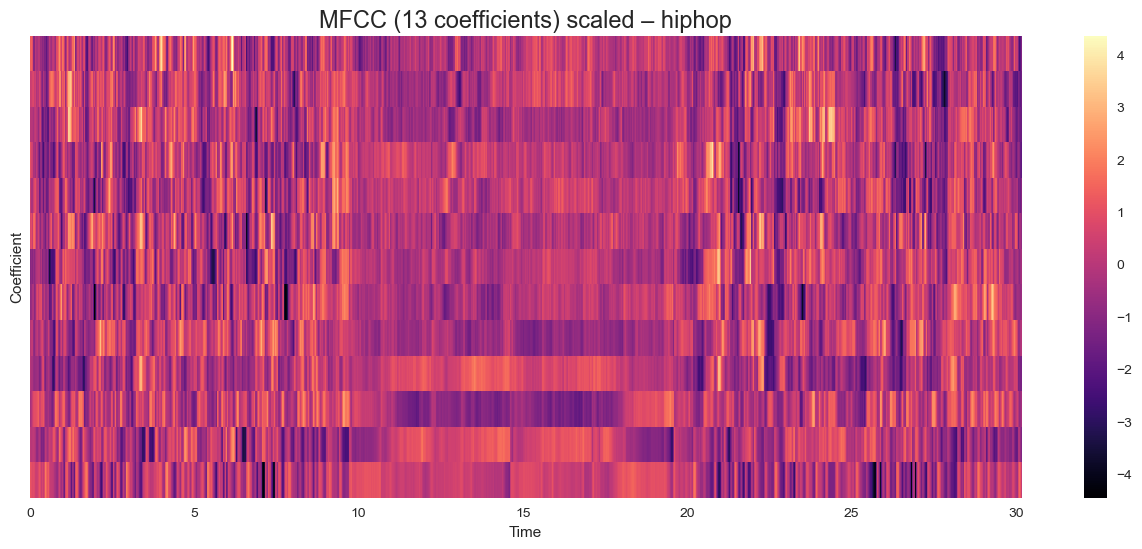

In [13]:
def show_mfcc(y, sr, genre):
    mfcc = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13, hop_length = 512)
    #plt.figure(figsize = (14, 4))
    #librosa.display.specshow(mfcc, sr = sr, hop_length = 512, x_axis = 'time', cmap = 'magma')
    #plt.colorbar()
    #plt.title(f"MFCC (13 coefficients) – {genre}", fontsize = 17)
    #plt.ylabel("Coeficiente")
    #plt.show()

    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    
    plt.figure(figsize = (16, 6))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap = 'magma')
    plt.colorbar()
    plt.title(f"MFCC (13 coefficients) scaled – {genre}", fontsize = 17)
    plt.ylabel("Coefficient")
    plt.show()

show_mfcc(sample_y, sample_sr, 'hiphop')

## Chroma Frequencies
Las frecuencias croma representan la intensidad de las 12 clases de tono (notas musicales) sin distinguir la octava. Cada clase de tono agrega energía de todas sus ocurrencias en distintas octavas. Son útiles para tareas como detección de tonalidad o progresiones armónicas.

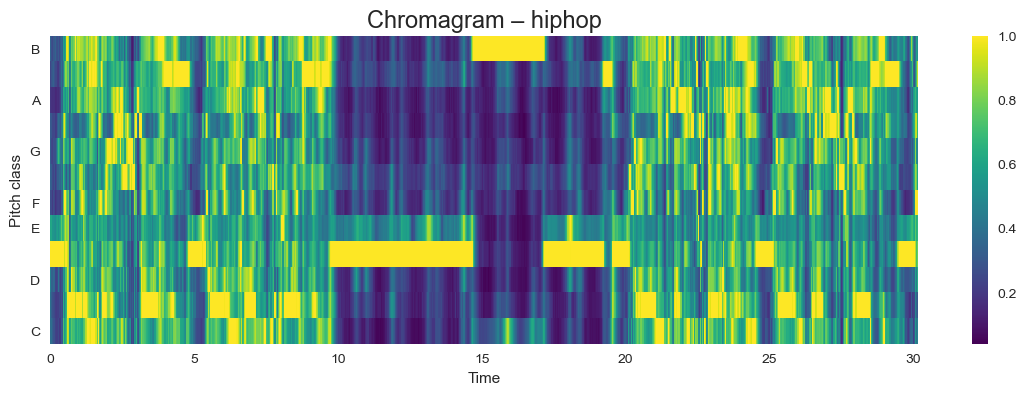

In [14]:
def show_chroma_freq(y, sr, genre):
    chroma = librosa.feature.chroma_cqt(y = y, sr = sr, hop_length = 512)
    plt.figure(figsize = (14, 4))
    librosa.display.specshow(chroma, x_axis = 'time', y_axis = 'chroma', cmap = 'viridis', hop_length = 512)
    plt.colorbar()
    plt.title(f"Chromagram – {genre}", fontsize = 17)
    plt.show()

show_chroma_freq(sample_y, sample_sr, 'hiphop')

## Análisis de Características de Audio para Clustering No Supervisado en el Dataset GTZAN
Para el agrupamiento automático de canciones en el dataset GTZAN mediante aprendizaje no supervisado, la elección de características de audio es fundamental para el éxito del algoritmo. A continuación, analizo las características más relevantes y proporciono argumentos sobre su idoneidad para clustering musical.

### Características Más Relevantes
__MFCC (Mel-Frequency Cepstral Coefficients)__

Los MFCC son altamente recomendables para el clustering musical por varias razones:

* Percepción humana: Los MFCC están diseñados para aproximar la percepción auditiva humana, utilizando la escala Mel que es lineal por debajo de 1000 Hz y logarítmica después
* Robustez: Son resistentes a variaciones en tono, acento y ruido, lo que los hace ideales para clustering de géneros musicales diversos
* Información espectral compacta: Capturan eficientemente la envolvente espectral y características timbrales
* Rendimiento probado: Han demostrado consistentemente alta precisión en tareas de clasificación musical, especialmente para instrumentos como bajo, flauta, órgano y voces

__Chroma Features__

Las características de chroma son muy valiosas para el clustering musical:

* Contenido armónico: Capturan información sobre clases de tono y contenido melódico/armónico
* Invariancia a octavas: Representan la información tonal independientemente de la octava específica
* Clustering por tonalidad: Permiten agrupar música por tonalidades musicales de manera no supervisada

__Spectral Centroid:__
* Mide el "brillo" o centro de gravedad espectral de la señal
* Útil para distinguir entre géneros con diferentes características timbrales

__Spectral Rolloff:__
* Describe la forma espectral, indicando la frecuencia por debajo de la cual se concentra el 85-95% de la energía
* Efectivo para discriminar géneros con diferentes distribuciones de energía en frecuencia

__Zero Crossing Rate (ZCR):__
* Tasa de cambios de signo en la señal de audio
* Especialmente útil para clasificar sonidos percusivos y distinguir entre voz y música

In [15]:
def show_genre_graphs(genre):
    audio_path = track_by_gender(os.path.join(data_path, genre))
    y, sr = librosa.load(audio_path, sr = None)
    dur = librosa.get_duration(y = y, sr = sr)
    
    print("="*150)
    print("="*150)
    print("="*150)

    show_mfcc(y, sr, genre)

    show_chroma_freq(y, sr, genre)

    show_spectral_centroid(y, sr, genre)

    show_spectral_rolloff(y, sr, genre)

    show_zcr(y, sr, genre)

    print("="*150)
    print("="*150)
    print("="*150)

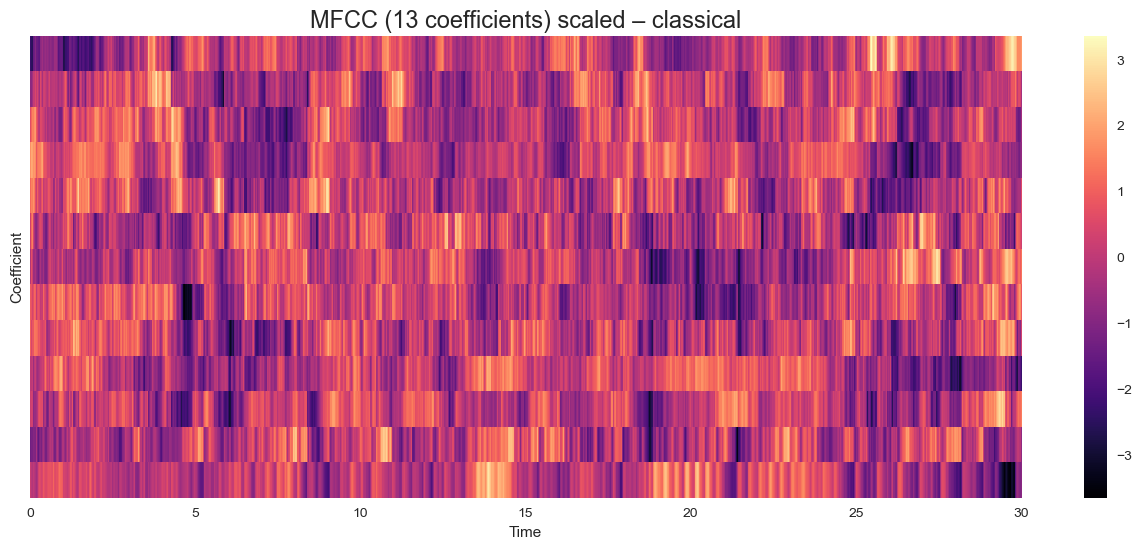

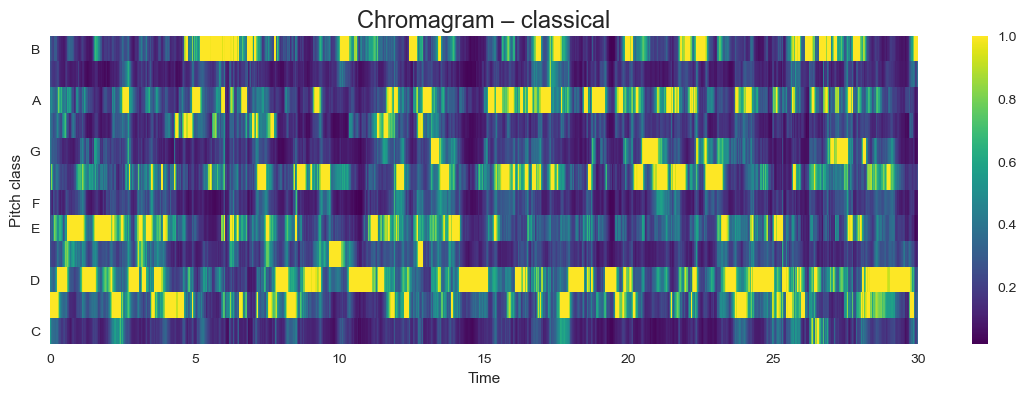

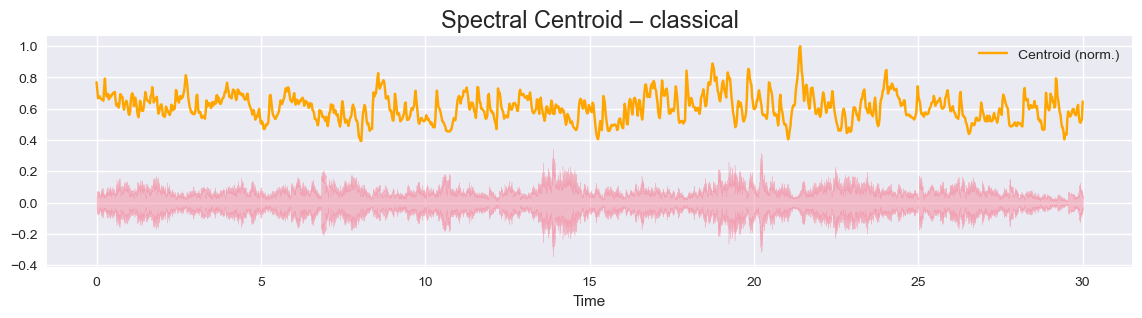

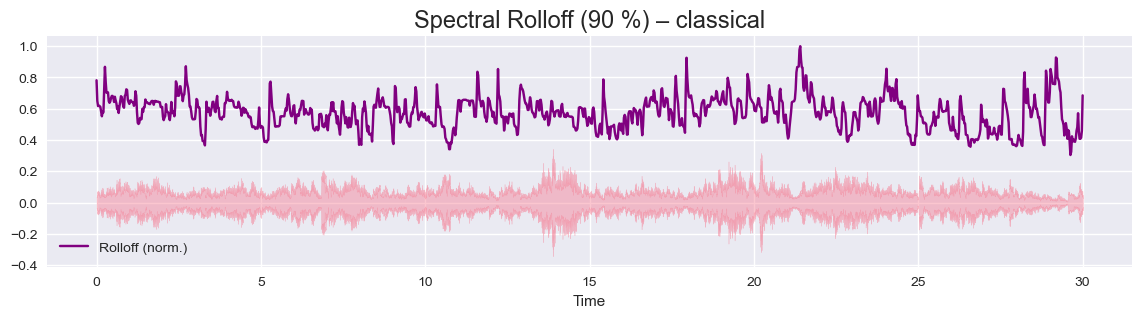

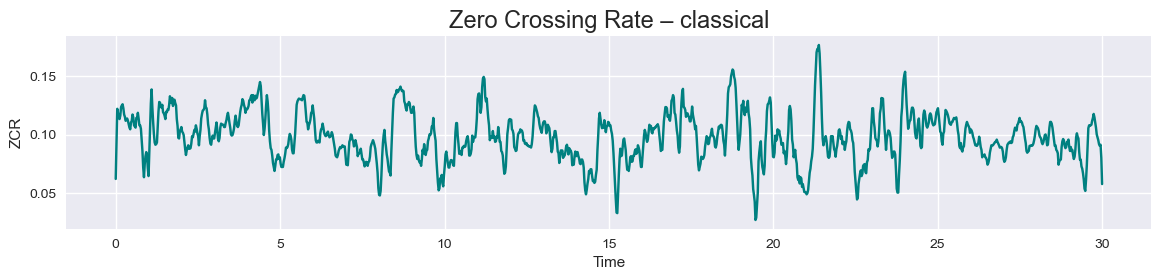

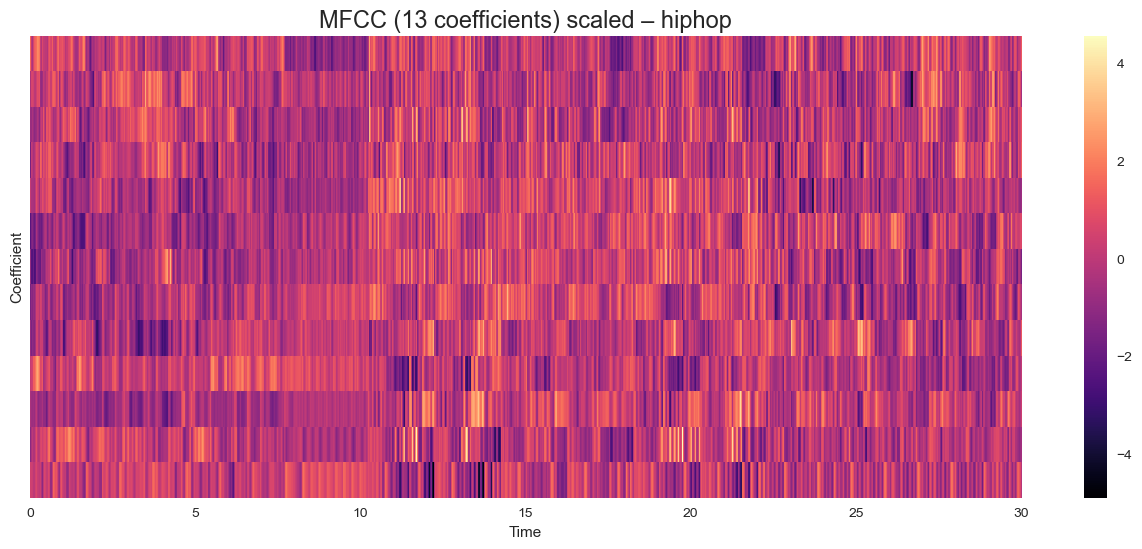

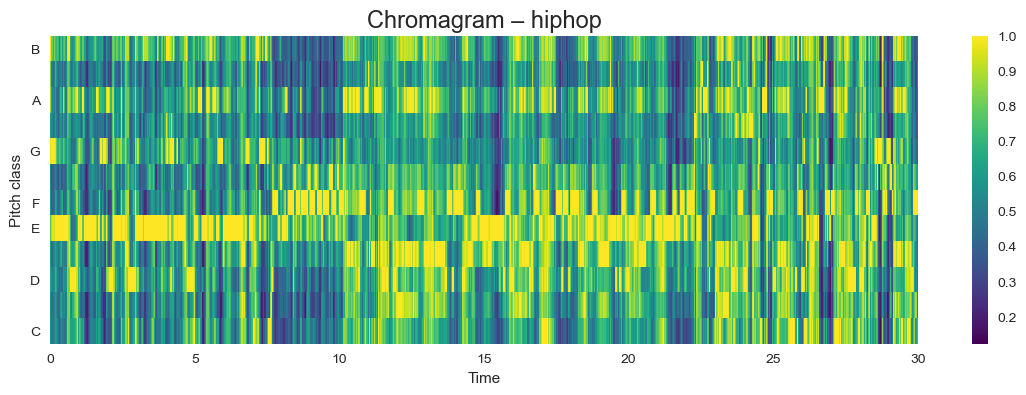

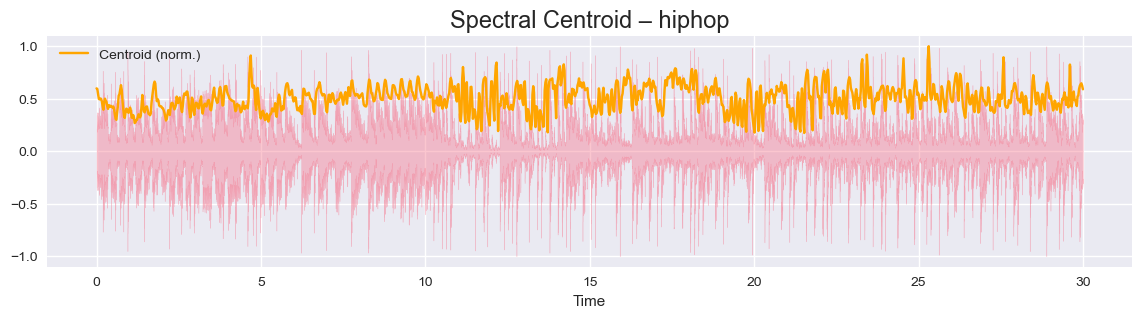

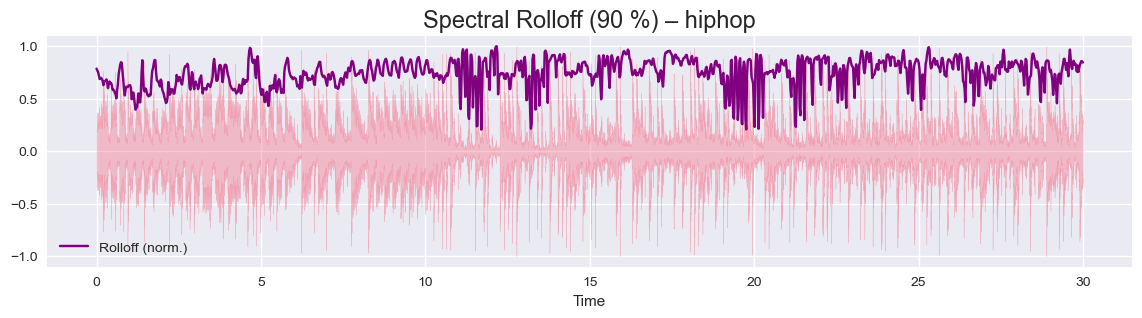

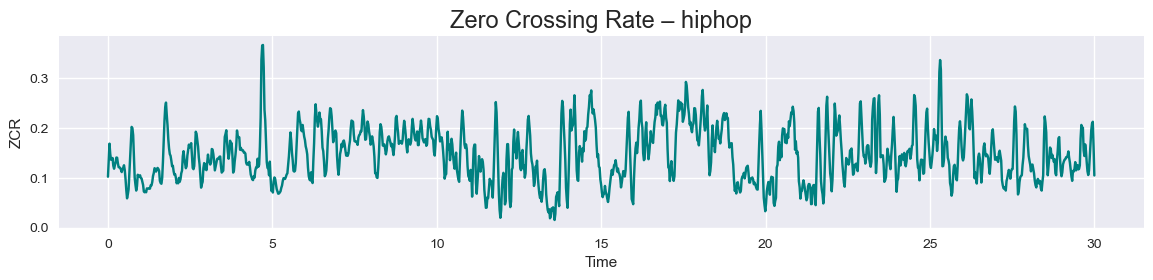

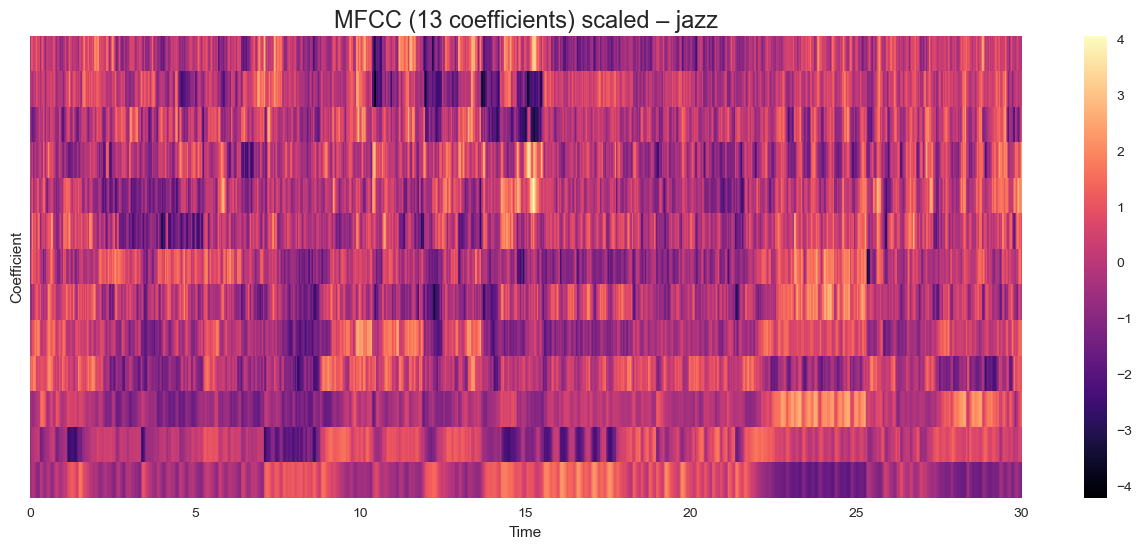

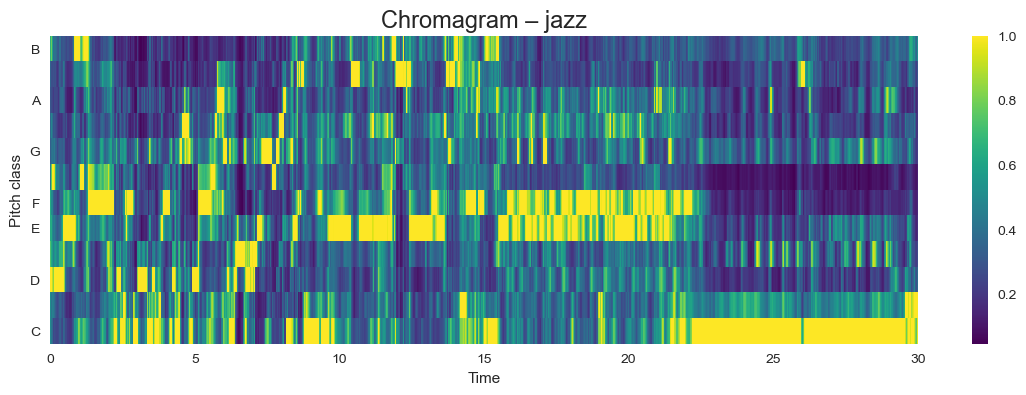

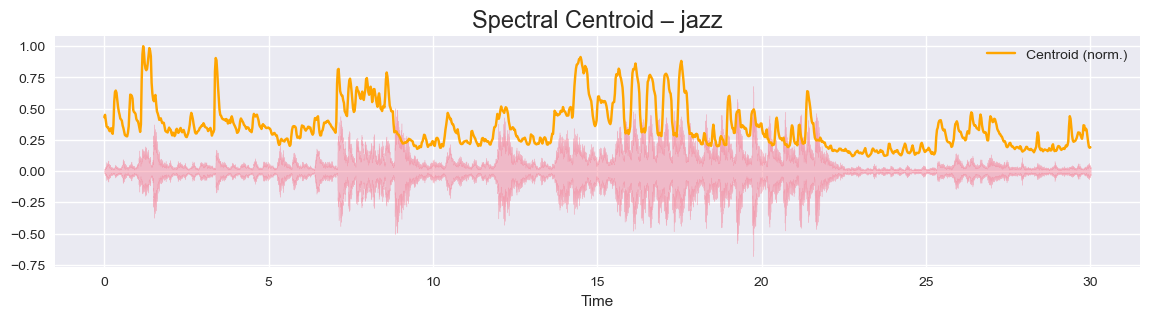

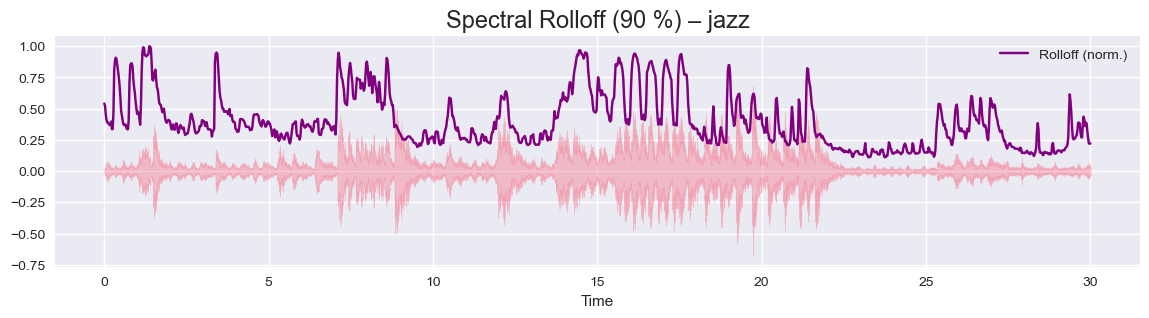

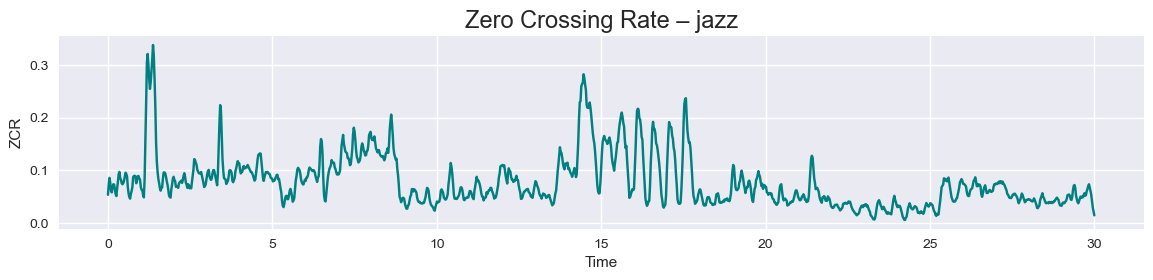

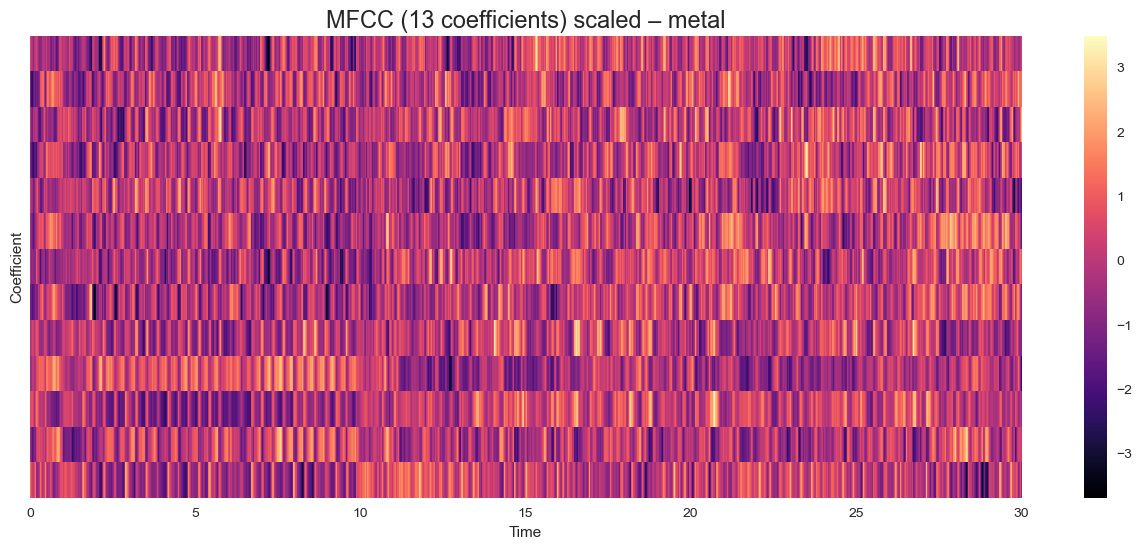

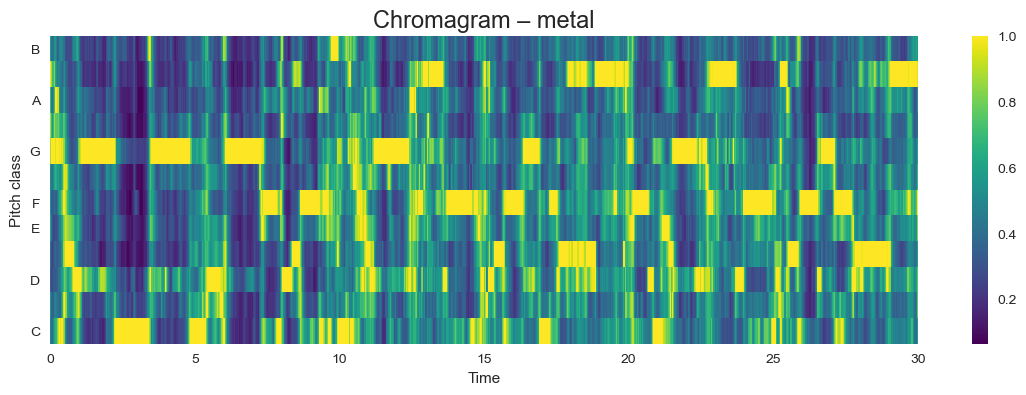

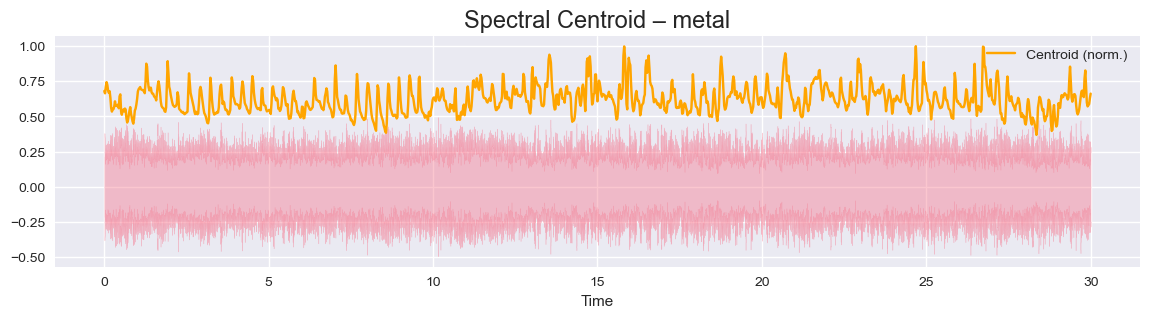

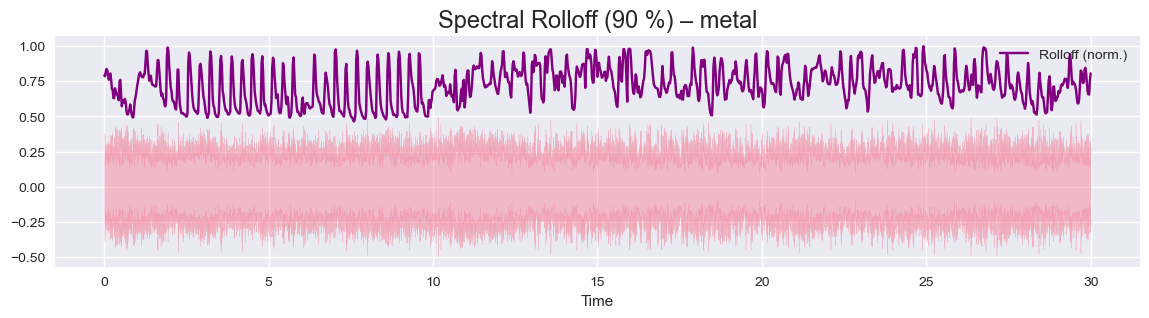

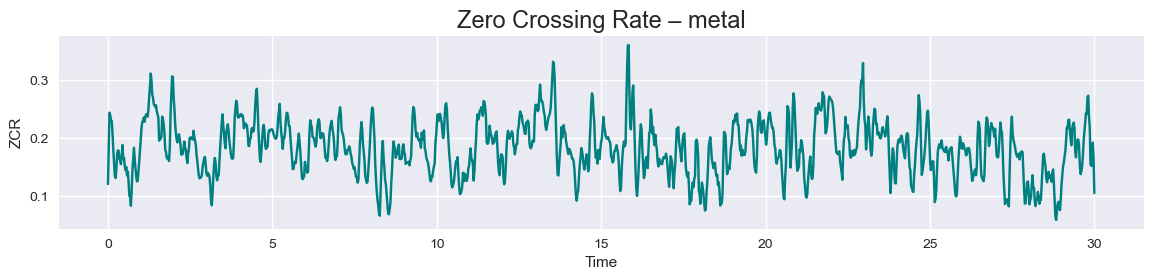

In [16]:
genres_to_show = ['classical', 'hiphop', 'jazz', 'metal']

for genre in genres_to_show:
    show_genre_graphs(genre)

# Recopilación y Preprocesamiento de Datos Musicales
## Curación del Dataset Mediante Validación y Limpieza
Este componente es fundamental porque el dataset GTZAN, aunque ampliamente utilizado en la literatura, presenta problemas de calidad documentados en estudios previos que incluyen archivos corruptos, variaciones en la calidad del audio y etiquetado inconsistente. La validación previa es esencial porque los archivos corruptos pueden introducir ruido sistemático en las características extraídas, comprometiendo la calidad del clustering.

In [17]:
def validate_and_clean_dataset(data_path):
    """
    Valida y limpia el dataset eliminando archivos corruptos
    """
    valid_files = []
    corrupted_files = []
    genre_counts = {}
    
    print(f"Explorando dataset en: {data_path}")
    
    # Verificar estructura del dataset
    for genre in genres:
        genre_path = os.path.join(data_path, genre)
        if os.path.exists(genre_path):
            genre_files = []
            
            for file in os.listdir(genre_path):
                if file.endswith('.wav'):
                    filepath = os.path.join(genre_path, file)
                    try:
                        # Validar que el archivo sea legible
                        y, sr = librosa.load(filepath, duration=5.0, sr=None)
                        if len(y) > 0 and sr > 0 and not np.any(np.isnan(y)):
                            valid_files.append(filepath)
                            genre_files.append(filepath)
                        else:
                            corrupted_files.append(filepath)
                            print(f"Archivo con problemas: {file}")
                    except Exception as e:
                        corrupted_files.append(filepath)
                        print(f"Error en {file}: {str(e)[:50]}")
            
            genre_counts[genre] = len(genre_files)
            print(f"{genre}: {len(genre_files)} archivos válidos")
        else:
            print(f"Directorio NO encontrado: {genre}")
            genre_counts[genre] = 0
    
    return valid_files, corrupted_files, genre_counts

La función implementa un mecanismo de validación robusta que: 
* Recorre recursivamente el directorio del dataset
* Intenta cargar cada archivo de audio utilizando librosa con una duración limitada para optimizar el tiempo de procesamiento
* Verifica que los datos cargados tengan contenido válido (longitud > 0 y tasa de muestreo > 0)
* Maneja excepciones para identificar archivos que no pueden ser procesados

## Pipeline Comprensivo de Extracción de Características
Este pipeline implementa una extracción multidimensional de características que abarca los cuatro dominios principales identificados en la literatura de MIR: espectrales, rítmicas, armónicas y de textura. La elección de estas características está fundamentada en investigación previa que demuestra su eficacia en tareas de clasificación musical. 

* Los MFCCs capturan información tímbrica fundamental y son ampliamente utilizados por su capacidad de modelar la percepción auditiva humana
* Las características espectrales (centroide, roll-off) proporcionan información complementaria sobre el contenido frecuencial
* ZCR (Zero Crossing Rate) es especialmente útil para distinguir entre contenido musical percusivo y tonal, proporcionando información sobre la naturaleza transitoria de la señal

In [18]:
def extract_audio_features(audio_path, sr=22050, hop_length=512):
    """
    Extrae el conjunto completo de características según los objetivos específicos
    """
    
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        
        # Validar que el audio no esté vacío
        if len(y) == 0:
            raise ValueError("Audio file is empty")
            
        features = {}
        
        # MFCCs
        try:
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)
            features['mfcc'] = mfcc
        except:
            features['mfcc'] = np.zeros((13, max(1, len(y)//hop_length)))
        
        # Chroma
        try:
            chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
            features['chroma'] = chroma
        except:
            features['chroma'] = np.zeros((12, max(1, len(y)//hop_length)))
        
        # Centroide espectral
        try:
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
            features['spectral_centroid'] = spectral_centroid
        except:
            features['spectral_centroid'] = np.array([[sr/4]]).repeat(max(1, len(y)//hop_length), axis=1)
        
        # Roll-off espectral
        try:
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
            features['spectral_rolloff'] = spectral_rolloff
        except:
            features['spectral_rolloff'] = np.array([[sr/2]]).repeat(max(1, len(y)//hop_length), axis=1)
        
        # Zero Crossing Rate
        try:
            zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
            features['zcr'] = zcr
        except:
            features['zcr'] = np.array([[0.1]]).repeat(max(1, len(y)//hop_length), axis=1)
        
    except Exception as e:
        print(f"Error crítico en extracción: {e}")
        # Retornar características mínimas válidas
        n_frames = 100  # Valor por defecto
        return {
            'mfcc': np.zeros((13, n_frames)),
            'chroma': np.zeros((12, n_frames)),
            'spectral_centroid': np.array([[sr/4]]).repeat(n_frames, axis=1),
            'zcr': np.array([[0.1]]).repeat(n_frames, axis=1),
        }
    else:
        return features

La función está estructurada modularmente, con cada bloque responsable de un tipo específico de características. Se utilizan parámetros estandarizados (sr=22050, hop_length=512) que son consistentes con las mejores prácticas en MIR. El formato de salida se normaliza utilizando arrays de numpy para garantizar compatibilidad con los algoritmos de clustering posteriores.

## Agregación de Estadísticas Temporales de Características
Esta función implementa la agregación temporal de características acústicas mediante el cálculo de estadísticas descriptivas robustas. Transforma secuencias temporales de características en vectores de características fijos, esenciales para algoritmos de clustering que requieren representaciones de dimensión constante.

In [19]:
def aggregate_features(features_dict):
    """
    Calcula estadísticas de largo plazo según el objetivo específico
    """
    
    aggregated = {}
    
    for feature_name, feature_values in features_dict.items():
        if feature_values.ndim == 2:  # Solo características temporales
            
            # Validar que no hay NaN/Inf antes de calcular estadísticas
            if np.any(np.isnan(feature_values)) or np.any(np.isinf(feature_values)):
                print(f"Valores problemáticos detectados en {feature_name}, aplicando limpieza...")
                feature_values = np.nan_to_num(feature_values, nan=0.0, posinf=1.0, neginf=-1.0)
            
            try:
                stats = {
                    'mean': np.mean(feature_values, axis=1),
                    'std': np.std(feature_values, axis=1),
                    'min': np.min(feature_values, axis=1),
                    'max': np.max(feature_values, axis=1),
                    'q25': np.percentile(feature_values, 25, axis=1),
                    'q50': np.percentile(feature_values, 50, axis=1),
                    'q75': np.percentile(feature_values, 75, axis=1)
                }
                    
                # Validar todas las estadísticas antes de agregar
                for stat_name, stat_values in stats.items():
                    stat_values = np.nan_to_num(stat_values, nan=0.0, posinf=1.0, neginf=-1.0)
                    for i, value in enumerate(stat_values):
                        aggregated[f'{feature_name}_{stat_name}_{i}'] = float(value)
                        
            except Exception as e:
                print(f"Error agregando {feature_name}: {e}")
                continue
    
    return aggregated

La función convierte características temporales 2D (coeficientes × frames) en vectores 1D de estadísticas fijas, permitiendo compatibilidad con algoritmos de clustering que requieren dimensionalidad constante.

Se calculan 7 descriptores estadísticos (media, desviación, mín, máx, Q25, mediana, Q75) que capturan tanto tendencias centrales como dispersión y forma de la distribución temporal.

El sistema aplica limpieza automática de NaN/Inf en dos niveles (entrada y salida) usando np.nan_to_num() para garantizar estabilidad numérica en el pipeline posterior.

## Preprocesamiento y Validación de Características
Función auxiliar que extrae las características acústicas, calcula sus estadísticas de largo plazo y valida que el vector resultante no contenga valores no numéricos. En caso de detectar NaN o infinitos, los sustituye por cero para mantener la estabilidad numérica del pipeline.

In [20]:
def extract_features_with_validation(filepath):
    """
    Función que extrae características con validación de NaN
    """
    try:
        # Extraer características usando tu función existente
        features = extract_audio_features(filepath)
        
        # Agregar estadísticas usando tu función existente
        aggregated_features = aggregate_features(features)
        
        # VALIDAR que no hay NaN en las características
        feature_values = list(aggregated_features.values())
        
        # Verificar NaN y valores infinitos
        if any(np.isnan(val) or np.isinf(val) for val in feature_values):
            print(f"NaN/Inf detectado en: {os.path.basename(filepath)}")
            # Reemplazar NaN/Inf con valores por defecto
            feature_values = [0.0 if (np.isnan(val) or np.isinf(val)) else val 
                            for val in feature_values]
            print(f"Valores corregidos para: {os.path.basename(filepath)}")
        
        return feature_values, True
        
    except Exception as e:
        print(f"Error procesando {os.path.basename(filepath)}: {str(e)[:100]}")
        return None, False

## Validación de Características
Esta celda recorre el dataset validado, extrae las características acústicas ya definidas y valida la ausencia de valores no numéricos.

In [21]:
valid_files, corrupted_files, genre_counts = validate_and_clean_dataset(data_path)

print(f"\nArchivos válidos: {len(valid_files)}")
print(f"Archivos corruptos: {len(corrupted_files)}")
print(f"Distribución por géneros:")
for genre, count in genre_counts.items():
    print(f"   {genre}: {count} archivos")

Explorando dataset en: Data/genres_original
blues: 100 archivos válidos
classical: 100 archivos válidos
country: 100 archivos válidos
disco: 100 archivos válidos
hiphop: 100 archivos válidos
Error en jazz.00054.wav: 
jazz: 99 archivos válidos
metal: 100 archivos válidos
pop: 100 archivos válidos
reggae: 100 archivos válidos
rock: 100 archivos válidos

Archivos válidos: 999
Archivos corruptos: 1
Distribución por géneros:
   blues: 100 archivos
   classical: 100 archivos
   country: 100 archivos
   disco: 100 archivos
   hiphop: 100 archivos
   jazz: 99 archivos
   metal: 100 archivos
   pop: 100 archivos
   reggae: 100 archivos
   rock: 100 archivos


## Construcción del Dataset
Esta sección ejecuta el procesamiento completo del dataset GTZAN validado, extrayendo características de cada archivo de audio y construyendo las matrices finales X (características) e y_true (etiquetas). Incluye control de progreso, manejo de errores y validación de la integridad del dataset resultante.

In [22]:
# Procesar archivos con validación
all_features = []
all_labels = []
processed_files = []
feature_names = None
processing_log = {'processed': 0, 'errors': 0, 'nan_fixed': 0}

print("Procesando archivos de audio con validación...")

for i, filepath in enumerate(valid_files):
    if i % 50 == 0:
        print(f"Progreso: {i}/{len(valid_files)} archivos procesados")
    
    # Extraer características con validación
    features, success = extract_features_with_validation(filepath)
    
    if success and features is not None:
        all_features.append(features)
        
        genre = os.path.basename(os.path.dirname(filepath))
        
        # Validar que el género existe en nuestra lista
        if genre in genres:
            genre_idx = genres.index(genre)
            all_labels.append(genre_idx)
            processed_files.append(filepath)
            processing_log['processed'] += 1
            
            # Obtener nombres de características en la primera iteración
            if feature_names is None and i == 0:
                # Recrear características para obtener nombres
                temp_features = extract_audio_features(filepath)
                temp_aggregated = aggregate_features(temp_features)
                feature_names = list(temp_aggregated.keys())
                print(f"{len(feature_names)} características identificadas")
        else:
            print(f"Género desconocido: {genre} en {filepath}")
            processing_log['errors'] += 1
    else:
        processing_log['errors'] += 1

# Crear arrays finales con validación
if len(all_features) > 0:
    X = np.array(all_features, dtype=np.float64)
    y_true = np.array(all_labels, dtype=np.int32)
    
    print(f"\nDATASET CREADO:")
    print(f"  - Muestras procesadas: {X.shape[0]}")
    print(f"  - Características por muestra: {X.shape[1]}")
    print(f"  - Géneros representados: {len(set(y_true))} (valores: {sorted(set(y_true))})")
    print(f"  - Rango de etiquetas: {min(y_true)} a {max(y_true)}")

Procesando archivos de audio con validación...
Progreso: 0/999 archivos procesados
196 características identificadas
Progreso: 50/999 archivos procesados
Progreso: 100/999 archivos procesados
Progreso: 150/999 archivos procesados
Progreso: 200/999 archivos procesados
Progreso: 250/999 archivos procesados
Progreso: 300/999 archivos procesados
Progreso: 350/999 archivos procesados
Progreso: 400/999 archivos procesados
Progreso: 450/999 archivos procesados
Progreso: 500/999 archivos procesados
Progreso: 550/999 archivos procesados
Progreso: 600/999 archivos procesados
Progreso: 650/999 archivos procesados
Progreso: 700/999 archivos procesados
Progreso: 750/999 archivos procesados
Progreso: 800/999 archivos procesados
Progreso: 850/999 archivos procesados
Progreso: 900/999 archivos procesados
Progreso: 950/999 archivos procesados

DATASET CREADO:
  - Muestras procesadas: 999
  - Características por muestra: 196
  - Géneros representados: 10 (valores: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
  - Ran

* Se reporta progreso cada 50 archivos con porcentaje de completitud para monitoreo durante ejecución prolongada.
* Los archivos problemáticos no interrumpen el proceso; se registran estadísticas detalladas para auditoría posterior.
* Verificación final de NaN e infinitos en la matriz resultante para garantizar compatibilidad con algoritmos de clustering.
  
El resultado es un dataset limpio y listo para la fase de clustering, con matrices X (características numéricas) e y_true (etiquetas de género) validadas y documentadas comprehensivamente.

## Construcción del DataFrame
Se consolidan todas las características acústicas extraídas y sus correspondientes metadatos en un DataFrame de pandas, proporcionando una estructura tabular organizada que facilita el análisis exploratorio y la posterior aplicación de algoritmos de clustering. El DataFrame resultante contiene tanto las características numéricas como la información contextual de cada pista musical.

In [23]:
print("\nCREACIÓN DEL DATAFRAME:")

# Crear DataFrame con todas las características extraídas
df = pd.DataFrame(X, columns=feature_names)

# Agregar columnas de metadatos
df['genre_idx'] = y_true
df['genre_name'] = [genres[idx] for idx in y_true]
df['file_path'] = processed_files
df['file_name'] = [os.path.basename(path) for path in processed_files]

print(f"   Dimensiones: {df.shape}")
print(f"   Columnas de características: {len(feature_names)}")
print(f"   Columnas de metadatos: 4 (genre_idx, genre_name, file_path, file_name)")

# Estadísticas del DataFrame
print(f"\nESTADÍSTICAS DEL DATAFRAME:")
print(f"   Valores nulos: {df.isnull().sum().sum()}")
print(f"   Tipos de datos únicos: {df.dtypes.value_counts().to_dict()}")


CREACIÓN DEL DATAFRAME:
   Dimensiones: (999, 200)
   Columnas de características: 196
   Columnas de metadatos: 4 (genre_idx, genre_name, file_path, file_name)

ESTADÍSTICAS DEL DATAFRAME:
   Valores nulos: 0
   Tipos de datos únicos: {dtype('float64'): 196, dtype('O'): 3, dtype('int32'): 1}


In [24]:
df.head()

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,zcr_std_0,zcr_min_0,zcr_max_0,zcr_q25_0,zcr_q50_0,zcr_q75_0,genre_idx,genre_name,file_path,file_name
0,-113.598824,121.570671,-19.162262,42.363941,-6.362266,18.621931,-13.699734,15.339802,-12.274304,10.970944,...,0.027694,0.033203,0.242676,0.064453,0.078125,0.096191,0,blues,Data/genres_original\blues\blues.00000.wav,blues.00000.wav
1,-207.523834,123.985138,8.947019,35.867149,2.909595,21.519472,-8.556513,23.370676,-10.103608,11.899242,...,0.038046,0.006348,0.323730,0.031250,0.047852,0.069336,0,blues,Data/genres_original\blues\blues.00001.wav,blues.00001.wav
2,-90.757164,140.440872,-29.084547,31.686693,-13.976547,25.753752,-13.664990,11.634442,-11.778322,9.714756,...,0.031731,0.012695,0.440918,0.059082,0.073730,0.087891,0,blues,Data/genres_original\blues\blues.00002.wav,blues.00002.wav
3,-199.575134,150.086105,5.663404,26.855278,1.770071,14.232647,-4.827845,9.286853,-0.756120,8.134435,...,0.020561,0.006348,0.145020,0.016113,0.030762,0.046875,0,blues,Data/genres_original\blues\blues.00003.wav,blues.00003.wav
4,-160.354172,126.209480,-35.581394,22.139256,-32.473549,10.850701,-23.350071,0.493249,-11.796538,1.203519,...,0.044205,0.039551,0.366211,0.070312,0.092773,0.122070,0,blues,Data/genres_original\blues\blues.00004.wav,blues.00004.wav


## Evaluación Comparativa de Algoritmos de Clustering
Esta función implementa la evaluación sistemática y comparativa de cuatro algoritmos de clustering (K-Means, GMM, DBSCAN y HDBSCAN) sobre subconjuntos específicos de características musicales. Incluye restricciones de rango para el número de clusters (5-20) y optimización automática de hiperparámetros para cada algoritmo, asegurando comparaciones justas y resultados musicalmente significativos.

In [25]:
def evaluate_subset(
        X_full, y_true, feature_names, subset_idx, subset_name,
        k_list=(6,8,10,12,15),          # para K-Means / GMM
        eps_list=(0.3,0.5,0.7,1.0,1.2,1.5,2.0),     # para DBSCAN
        min_samples_list=(3,5,7,10,15), # para DBSCAN
        min_cluster_sizes=(5,7,10,12,15,18,20),  # para HDBSCAN
        target_cluster_range=(5, 20)
    ):

    if not subset_idx:
        return None
    
    # --------- Pre-procesado ----------
    X_sub = X_full[:, subset_idx]
    X_sub = StandardScaler().fit_transform(X_sub)
    
    # Lista de algoritmos disponibles
    algorithms = ['kmeans', 'gmm', 'dbscan', 'hdbscan']
    
    algo_best = {}
    for algo in algorithms:
        algo_best[algo] = {
            'score': -1,
            'config': None,
            'sil': -1,
            'ari': 0,
            'n_clusters': 0
        }
    
    # ---------- FUNCIONES HELPER CON FILTRADO DE CLUSTERS ----------
    def is_valid_cluster_count(n_clusters):
        """Verifica si el número de clusters está en el rango válido"""
        return target_cluster_range[0] <= n_clusters <= target_cluster_range[1]
    
    def scoring_with_cluster_penalty(labels, target_k):
        """Función de scoring que penaliza clusters fuera del rango"""
        n_clust = len(set(labels)) - (1 if -1 in labels else 0)
        
        # FILTRO CRÍTICO: rechazar si está fuera del rango
        if not is_valid_cluster_count(n_clust):
            return -1
        
        mask = labels != -1
        if np.sum(mask) < 10:
            return -1
        try:
            sil = silhouette_score(X_sub[mask], labels[mask])
            ari = adjusted_rand_score(y_true[mask], labels[mask])
            k_pen = n_clust/target_k if target_k else 1
            return 0.4*sil + 0.3*ari + 0.3*k_pen
        except:
            return -1
    
    def update_best(algo, labels, target_k, cfg):
        """Función para actualizar solo si cumple restricciones de clusters"""
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # FILTRO PRINCIPAL: Solo procesar si está en rango válido
        if not is_valid_cluster_count(n_clusters):
            return  # Salir sin actualizar
        
        score = scoring_with_cluster_penalty(labels, target_k)
        if score > algo_best[algo]['score']:
            try:
                mask = labels != -1
                sil_val = silhouette_score(X_sub[mask], labels[mask]) if len(set(labels[mask])) > 1 else -1
                ari_val = adjusted_rand_score(y_true[mask], labels[mask]) if len(set(labels[mask])) > 1 else 0
                
                algo_best[algo] = {
                    'score': score,
                    'sil': sil_val,
                    'ari': ari_val,
                    'n_clusters': n_clusters,
                    'config': cfg
                }
            except Exception as e:
                pass
    
    # --------- EVALUAR ALGORITMOS CON RESTRICCIONES ----------
    
    # K-Means y GMM
    for k in k_list:
        try:
            km_labels = KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(X_sub)
            update_best('kmeans', km_labels, k, {'k':k})
        except:
            pass
        
        try:
            gmm_labels = GaussianMixture(n_components=k, random_state=42, max_iter=200).fit_predict(X_sub)
            update_best('gmm', gmm_labels, k, {'k':k})
        except:
            pass
    
    # DBSCAN con búsqueda exhaustiva para encontrar 5-20 clusters
    dbscan_valid_configs = 0
    
    for eps, ms in itertools.product(eps_list, min_samples_list):
        try:
            db = DBSCAN(eps=eps, min_samples=ms)
            db_labels = db.fit_predict(X_sub)
            n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
            
            # Solo procesar si está en rango válido
            if is_valid_cluster_count(n_clusters):
                dbscan_valid_configs += 1
                update_best('dbscan', db_labels, None, {'eps':eps,'min_samples':ms})
        except:
            pass
    
    print(f"DBSCAN: {dbscan_valid_configs} configuraciones válidas encontradas")

    # HDBSCAN
    
    hdbscan_valid_configs = 0
    
    for min_cluster_size in min_cluster_sizes:
        # Probar diferentes min_samples para HDBSCAN
        for min_samples_factor in [0.3, 0.5, 0.7, 1.0]:
            min_samples_hdb = max(3, int(min_cluster_size * min_samples_factor))
            
            try:
                hdb = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples_hdb,
                    cluster_selection_method='eom',
                    allow_single_cluster=False
                )
                hdb_labels = hdb.fit_predict(X_sub)
                n_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
                
                # Solo procesar si está en rango válido
                if is_valid_cluster_count(n_clusters):
                    hdbscan_valid_configs += 1
                    update_best('hdbscan', hdb_labels, None, 
                               {'min_cluster_size':min_cluster_size, 
                                'min_samples':min_samples_hdb})
            except:
                pass
        
    print(f"HDBSCAN: {hdbscan_valid_configs} configuraciones válidas encontradas")
    
    # -------- DEVOLVER SOLO ALGORITMOS CON RESULTADOS VÁLIDOS -------
    all_results = []
    for algo_name in algorithms:
        if algo_best[algo_name]['score'] > -1:  # Solo si tiene resultados válidos
            result = {
                'subset': subset_name,
                'n_features': len(subset_idx),
                'algorithm': algo_name,
                'config': algo_best[algo_name]['config'],
                'n_clusters': algo_best[algo_name]['n_clusters'],
                'silhouette': algo_best[algo_name]['sil'],
                'ari': algo_best[algo_name]['ari'],
                'combined': algo_best[algo_name]['score']
            }
            all_results.append(result)
            
            # Confirmar que está en rango
            n_clust = result['n_clusters']
            if is_valid_cluster_count(n_clust):
                print(f"{algo_name}: {n_clust} clusters (válido)")
            else:
                print(f"{algo_name}: {n_clust} clusters (fuera de rango)")
    
    return all_results

* La función garantiza que todos los algoritmos generen entre 5-20 clusters, eliminando configuraciones con agrupaciones demasiado simples o excesivamente fragmentadas que no son útiles para clustering musical.
* Cada algoritmo se evalúa con múltiples configuraciones paramétricas mediante grid search, asegurando que la comparación se realice con la configuración óptima de cada método.
* Se utiliza una combinación ponderada de Silhouette Score (40%), ARI vs géneros (30%) y penalización por número de clusters (30%) para balancear calidad geométrica, correspondencia semántica y parsimonia del modelo.

## Definición de Subconjuntos de Características y Evaluación Comparativa
Se implementa la definición sistemática de subconjuntos de características acústicas y se ejecuta la evaluación comparativa de algoritmos de clustering sobre cada subconjunto. El sistema genera combinaciones específicas de características basadas en la literatura MIR y evalúa todos los algoritmos implementados (K-Means, GMM, DBSCAN, HDBSCAN) con restricciones de rango de clusters musicalmente significativo.

In [26]:
def find_feature_indices(feature_names, keywords):
    """Encuentra índices de características que contienen alguna de las palabras clave"""
    indices = []
    for i, name in enumerate(feature_names):
        if any(keyword.lower() in name.lower() for keyword in keywords):
            indices.append(i)
    return indices

# índices de ayuda
mfcc_idx = find_feature_indices(feature_names, ['mfcc'])
centroid_idx = find_feature_indices(feature_names, ['spectral_centroid'])
rolloff_idx = find_feature_indices(feature_names, ['spectral_rolloff'])
zcr_idx = find_feature_indices(feature_names, ['zcr'])
chroma_idx = find_feature_indices(feature_names, ['chroma'])
top_indices = [i for i in range(min(20, len(feature_names)))]

# subconjuntos definitivos
feature_subsets = {
    'MFCC_only': mfcc_idx,
    'MFCC+Centroid': mfcc_idx + centroid_idx,
    'MFCC+ZCR': mfcc_idx + zcr_idx,
    'MFCC+Centroid+ZCR': mfcc_idx + centroid_idx + zcr_idx,
    'MFCC+Rolloff': mfcc_idx + rolloff_idx,
    'MFCC+Chroma': mfcc_idx + chroma_idx,
    'Top20': top_indices,
    'All_Spectral': mfcc_idx + centroid_idx + rolloff_idx + zcr_idx
}

print("SUBCONJUNTOS DEFINIDOS:")
for name, idx in feature_subsets.items():
    print(f"   {name}: {len(idx)} features")

# ================================================================
# EJECUTAR EVALUACIÓN CON RESTRICCIONES 5-20 CLUSTERS
# ================================================================
algorithm_count = 4
algorithm_names = "K-Means, GMM, DBSCAN y HDBSCAN"

all_results = []  # Lista para almacenar TODOS los resultados

for name, idx in feature_subsets.items():
    if len(idx) > 0:  # Solo evaluar si hay características válidas
        print(f"\n{'='*60}")
        print(f"EVALUANDO SUBCONJUNTO: {name} ({len(idx)} features)")
        print(f"{'='*60}")
        
        # USAR LA FUNCIÓN MODIFICADA CON RESTRICCIONES
        subset_results = evaluate_subset(X, y_true, feature_names, idx, name)
        
        if subset_results and len(subset_results) > 0:
            # Añadir todos los resultados a la lista general
            all_results.extend(subset_results)
            
            # Mostrar resultados para este subconjunto
            print(f"\nRESULTADOS VÁLIDOS PARA {name}:")
            print(f"{'Algorithm':<10} {'Config':<25} {'Clusters':<8} {'Silhouette':<10} {'ARI':<8} {'Score':<8}")
            print("-" * 75)
            
            # Ordenar por score combinado para este subconjunto
            subset_results_sorted = sorted(subset_results, key=lambda x: x['combined'], reverse=True)
            
            for i, res in enumerate(subset_results_sorted, 1):
                config_str = str(res['config'])[:24]
                print(f"{i} {res['algorithm']:<10} {config_str:<25} {res['n_clusters']:<8} "
                      f"{res['silhouette']:<10.3f} {res['ari']:<8.3f} {res['combined']:<8.3f}")
        else:
            print(f"{name}: Sin configuraciones que generen 5-20 clusters")

print(f"\nRESULTADOS TOTALES OBTENIDOS: {len(all_results)} configuraciones válidas (5-20 clusters)")

SUBCONJUNTOS DEFINIDOS:
   MFCC_only: 91 features
   MFCC+Centroid: 98 features
   MFCC+ZCR: 98 features
   MFCC+Centroid+ZCR: 105 features
   MFCC+Rolloff: 98 features
   MFCC+Chroma: 175 features
   Top20: 20 features
   All_Spectral: 112 features

EVALUANDO SUBCONJUNTO: MFCC_only (91 features)
DBSCAN: 0 configuraciones válidas encontradas
HDBSCAN: 0 configuraciones válidas encontradas
kmeans: 6 clusters (válido)
gmm: 6 clusters (válido)

RESULTADOS VÁLIDOS PARA MFCC_only:
Algorithm  Config                    Clusters Silhouette ARI      Score   
---------------------------------------------------------------------------
1 gmm        {'k': 6}                  6        0.180      0.162    0.421   
2 kmeans     {'k': 6}                  6        0.163      0.177    0.418   

EVALUANDO SUBCONJUNTO: MFCC+Centroid (98 features)
DBSCAN: 0 configuraciones válidas encontradas
HDBSCAN: 0 configuraciones válidas encontradas
kmeans: 6 clusters (válido)
gmm: 6 clusters (válido)

RESULTADOS VÁLID

* Se definen combinaciones específicas de características basadas en evidencia científica MIR, incluyendo MFCC como base fundamental y combinaciones con características complementarias (centroides, ZCR, rolloff, chroma).

* El sistema evalúa cuatro algoritmos diferentes sobre cada subconjunto de características, proporcionando una matriz completa de rendimiento que permite identificar las mejores combinaciones algoritmo-características.

* La imposición del rango 5-20 clusters asegura que todos los resultados sean prácticamente útiles para aplicaciones musicales reales, eliminando agrupaciones demasiado simples o excesivamente fragmentadas.

## Resumen Global de Configuraciones de Clustering
Esta sección construye y muestra una tabla resumen con las mejores configuraciones encontradas para cada algoritmo de clustering, respetando la restricción de generar entre 5 y 20 clusters. Además, se presentan estadísticas de distribución de clusters y un análisis agregado por algoritmo.

In [27]:
print(f"\nTABLA RESUMEN GLOBAL")
print("="*95)

# Crear DataFrame con todos los resultados
if len(all_results) > 0:
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('combined', ascending=False)
    
    print(f"{'Rank':<4} {'Subconjunto':<18} {'Algorithm':<15} {'Config':<16} {'Clusters':<12} {'Sil':<8} {'ARI':<8} {'Score':<8}")
    print("-" * 100)
    
    for i, (_, row) in enumerate(results_df.iterrows(), 1):
        config_str = str(row['config'])[:14]
        
        print(f"{i:2d}. {row['subset']:<18} {row['algorithm']:<15} {config_str:<20} "
              f"{row['n_clusters']:<8} {row['silhouette']:<8.3f} {row['ari']:<8.3f} {row['combined']:<8.3f}")
    
    # Verificar restricción de clusters
    print(f"\nVERIFICACIÓN DE RESTRICCIONES:")
    print("="*50)
    cluster_counts = results_df['n_clusters'].value_counts().sort_index()
    print("Distribución de clusters encontrados:")
    for n_clust, count in cluster_counts.items():
        print(f"  {n_clust} clusters: {count} configuraciones")
    
    # Análisis por algoritmo
    print(f"\nANÁLISIS POR ALGORITMO:")
    print("="*60)
    
    available_algorithms = ['kmeans', 'gmm', 'dbscan', 'hdbscan']
    
    for algo in available_algorithms:
        if algo in results_df['algorithm'].values:
            algo_data = results_df[results_df['algorithm'] == algo]
            count = len(algo_data)
            avg_score = algo_data['combined'].mean()
            max_score = algo_data['combined'].max()
            avg_sil = algo_data['silhouette'].mean()
            avg_ari = algo_data['ari'].mean()
            cluster_range = f"{algo_data['n_clusters'].min()}-{algo_data['n_clusters'].max()}"
            
            print(f"{algo.upper():<8}: {count} configs | Clusters: {cluster_range} | Avg Score: {avg_score:.3f} | "
                  f"Max Score: {max_score:.3f} | Avg Sil: {avg_sil:.3f} | Avg ARI: {avg_ari:.3f}")
    
    # Top configuraciones globales
    top_count = min(5, len(results_df))
    print(f"\nTOP {top_count} CONFIGURACIONES:")
    print("="*60)
    top_configs = results_df.head(top_count)
    
    for i, (_, row) in enumerate(top_configs.iterrows(), 1):
        print(f"{i}. {row['subset']} con {row['algorithm'].upper()}")
        print(f"   {row['n_clusters']} clusters")
        print(f"   Configuración: {row['config']}")
        print(f"   Métricas: Silhouette: {row['silhouette']:.3f}, ARI: {row['ari']:.3f}, Score: {row['combined']:.3f}")
        print()


TABLA RESUMEN GLOBAL
Rank Subconjunto        Algorithm       Config           Clusters     Sil      ARI      Score   
----------------------------------------------------------------------------------------------------
 1. Top20              dbscan          {'eps': 1.5, '       18       0.372    0.381    0.563   
 2. Top20              hdbscan         {'min_cluster_       5        0.324    0.095    0.458   
 3. All_Spectral       gmm             {'k': 6}             6        0.184    0.182    0.428   
 4. MFCC+Centroid      kmeans          {'k': 6}             6        0.180    0.185    0.428   
 5. All_Spectral       kmeans          {'k': 6}             6        0.174    0.184    0.425   
 6. MFCC+Centroid+ZCR  kmeans          {'k': 6}             6        0.173    0.185    0.425   
 7. MFCC+ZCR           kmeans          {'k': 6}             6        0.169    0.187    0.424   
 8. Top20              kmeans          {'k': 6}             6        0.168    0.186    0.423   
 9. MFCC+Cen